# Basic regression: Predict fuel efficiency

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [66]:
#test_labelseaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

ERROR: Command errored out with exit status 128: git clone -q https://github.com/tensorflow/docs 'C:\Users\reddy\AppData\Local\Temp\pip-req-build-rnerro66' Check the logs for full command output.


In [67]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [68]:
try:
    %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(keras.__version__)

2.3.1
2.4.0


In [69]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/auto+mpg).

### Get the data
First download the dataset.

In [70]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\reddy\\.keras\\datasets\\auto-mpg.data'

Import it using pandas

In [71]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

In [72]:
dataset.shape

(398, 8)

### Clean the data

The dataset contains a few unknown values.

In [73]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

To keep this initial tutorial simple drop those rows.

In [74]:
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [75]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [76]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Europe  Japan  USA  
393          82       0      0    1  
394          82       1      0    0  
395          82       0      0    1  
396          82       0      0    1  
397          82       0      0    1

In [77]:
from pandas_profiling import ProfileReport

In [78]:
ProfileReport(dataset)

c:\users\reddy\appdata\local\programs\python\python36\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
c:\users\reddy\appdata\local\programs\python\python36\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
c:\users\reddy\appdata\local\programs\python\python36\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
c:\users\reddy\appdata\local\programs\python\python36\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
c:\users\reddy\appdata\local\programs\python\python36\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
c:\users\reddy\appdata\local\programs\python\python36\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid 

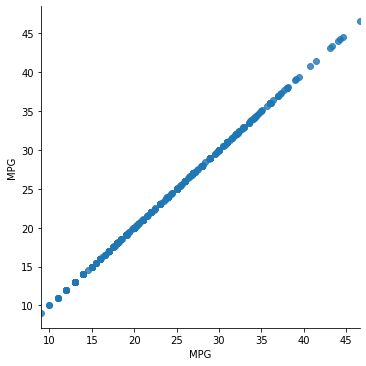

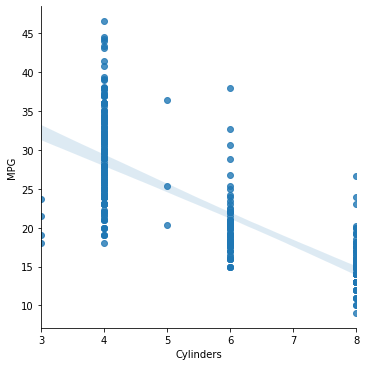

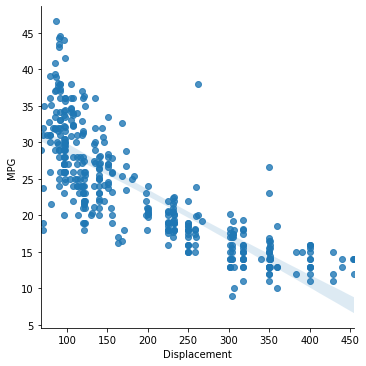

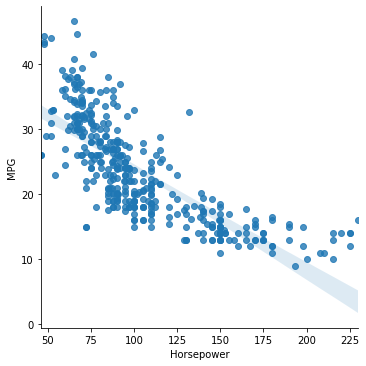

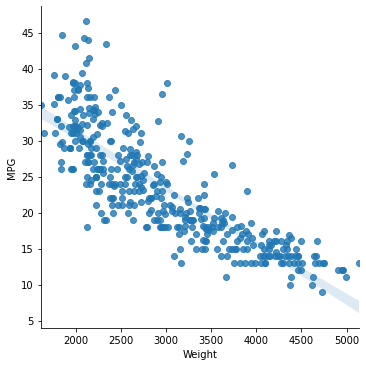

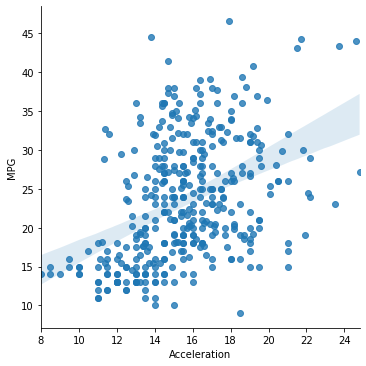

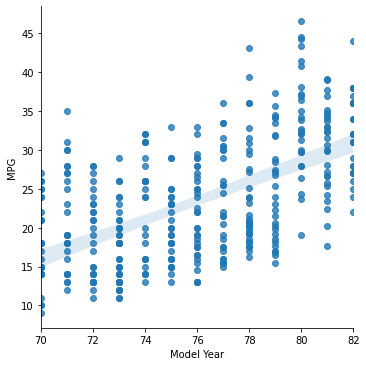

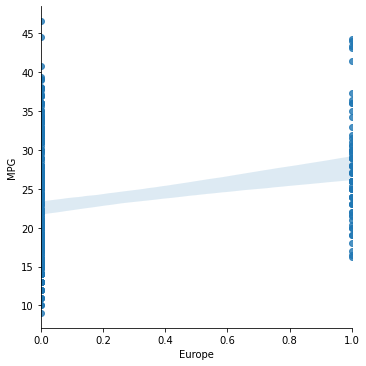

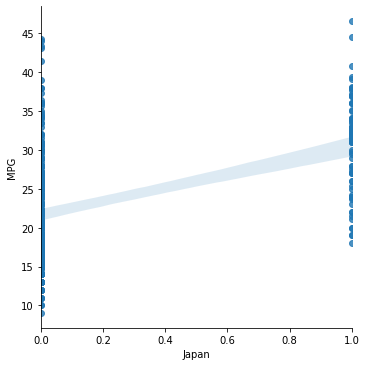

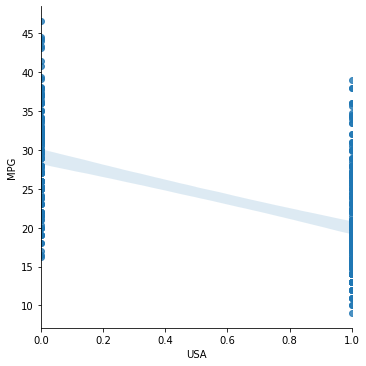

In [79]:
for i in dataset.columns.values:
    sns.lmplot(x = i ,y='MPG',data=dataset)

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [80]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [81]:
train_dataset.shape

(314, 10)

In [82]:
test_dataset.shape

(78, 10)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

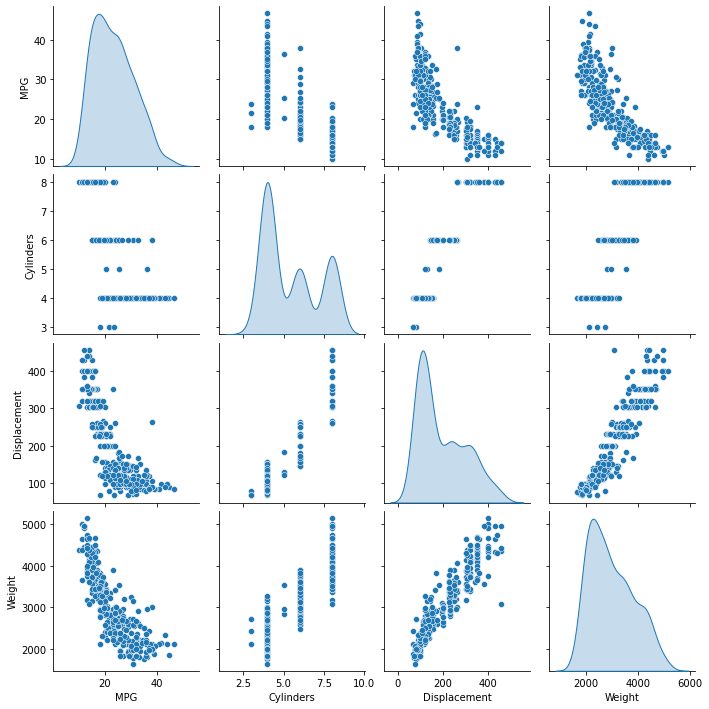

In [83]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Also look at the overall statistics:

In [84]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
Europe           0.00     1.0  
Japan            0.00     1.0  
USA              1.00     1.0

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [85]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [86]:
train_labels.shape

(314,)

In [87]:
test_labels.shape

(78,)

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [88]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [89]:
normed_train_data

Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
146  -0.869348     -1.009459   -0.784052 -1.025303     -0.379759   -0.516397   
282  -0.869348     -0.530218   -0.442811 -0.118796      0.624102    0.843910   
69    1.483887      1.482595    1.447140  1.736877     -0.738281   -1.060519   
378  -0.869348     -0.865687   -1.099044 -1.025303     -0.308055    1.660094   
331  -0.869348     -0.942365   -0.994047 -1.001603      0.875068    1.115971   
..         ...           ...         ...       ...           ...         ...   
281   0.307270      0.044872   -0.521559 -0.000298      0.946772    0.843910   
229   1.483887      1.961837    1.972127  1.457223     -1.598734    0.299787   
150  -0.869348     -0.836932   -0.311564 -0.710099     -0.021237   -0.516397   
145  -0.869348     -1.076553   -1.151543 -1.169870      1.233589   -0.516397   
182  -0.869348     -0.846517   -0.495310 -0.623596     -0.021237    0.027726   

       Europe     Japan       USA  
146 -0.465148 -0.495225  0.774676  
282 -0.465148 -0.495225  0.774676  
69  -0.465148 -0.495225  0.774676  
378 -0.465148 -0.495225  0.774676  
331 -0.465148  2.012852 -1.286751  
..        ...       ...       ...  
281 -0.465148 -0.495225  0.774676  
229 -0.465148 -0.495225  0.774676  
150 -0.465148  2.012852 -1.286751  
145 -0.465148  2.012852 -1.286751  
182  2.143005 -0.495225 -1.286751  

[314 rows x 9 columns]

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [90]:
len(train_dataset.keys())

9

In [91]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),  # shape (64,9) input Layers
        layers.Dense(64, activation='relu'), # Hidden Layer 
        layers.Dense(1) # output Layer
      ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model

In [92]:
model = build_model()
model

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [93]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [94]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.16405058],
       [-0.31731266],
       [-0.19518849],
       [-0.23990837],
       [-0.56918234],
       [-0.5433642 ],
       [-0.60153353],
       [-1.3137863 ],
       [-0.30667877],
       [-0.58231276]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [95]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:586.9592,  mae:22.9168,  mse:586.9592,  val_loss:580.7550,  val_mae:22.7184,  val_mse:580.7550,  
....................................................................................................
Epoch: 100, loss:6.1604,  mae:1.7408,  mse:6.1604,  val_loss:8.3383,  val_mae:2.1925,  val_mse:8.3383,  
....................................................................................................
Epoch: 200, loss:5.2889,  mae:1.5828,  mse:5.2889,  val_loss:8.0989,  val_mae:2.2124,  val_mse:8.0989,  
....................................................................................................
Epoch: 300, loss:4.7739,  mae:1.4765,  mse:4.7739,  val_loss:8.3947,  val_mae:2.2396,  val_mse:8.3947,  
....................................................................................................
Epoch: 400, loss:4.4811,  mae:1.4361,  mse:4.4811,  val_loss:8.1985,  val_mae:2.2052,  val_mse:8.1985,  
..............................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [96]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

loss        mae         mse    val_loss    val_mae     val_mse  epoch
0  586.959229  22.916836  586.959229  580.755005  22.718449  580.755005      0
1  536.816406  21.776243  536.816406  529.678101  21.565107  529.678101      1
2  489.708282  20.676855  489.708282  476.014954  20.290865  476.014954      2
3  439.555908  19.441227  439.555908  418.749146  18.843237  418.749146      3
4  387.225708  18.068424  387.225708  361.110962  17.249966  361.110962      4

In [97]:
hist.tail()

loss       mae       mse   val_loss   val_mae    val_mse  epoch
995  2.414548  1.034735  2.414548   9.672263  2.378759   9.672263    995
996  2.433162  1.081495  2.433162   9.167738  2.307523   9.167738    996
997  2.383155  1.047850  2.383155  10.159228  2.407068  10.159228    997
998  2.464144  1.067138  2.464144  10.603274  2.462381  10.603274    998
999  2.250499  0.975747  2.250499   9.604145  2.346127   9.604145    999

In [98]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

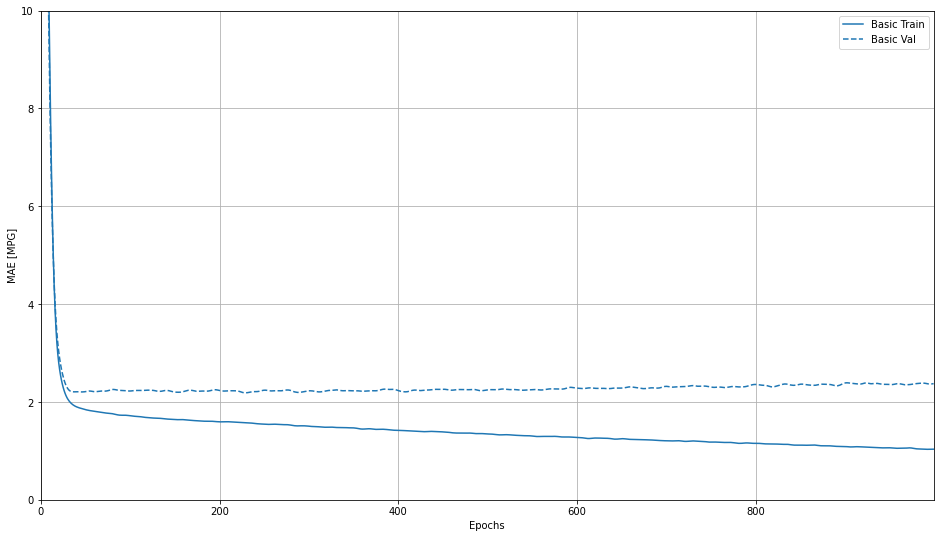

In [99]:
plt.figure(figsize=(16,9))
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

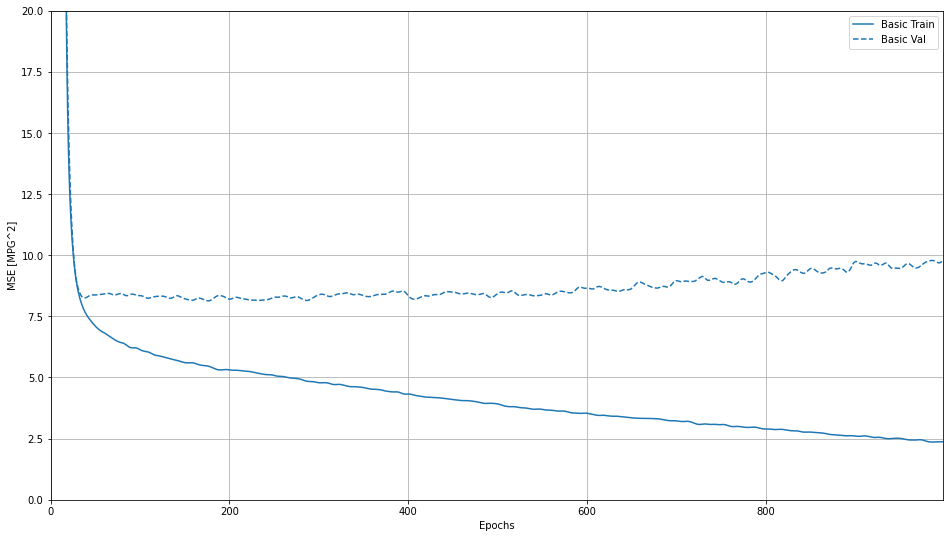

In [100]:
plt.figure(figsize=(16,9))
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [64]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:566.2765,  mae:22.5267,  mse:566.2765,  val_loss:557.3906,  val_mae:22.2832,  val_mse:557.3906,  
......................................................

Text(0, 0.5, 'MAE [MPG]')

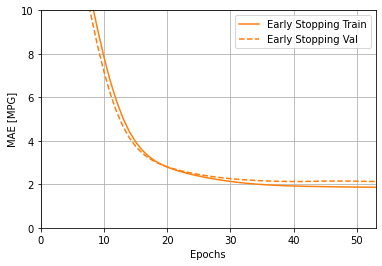

In [65]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [101]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:10.2f} MPG".format(mae))

3/3 - 0s - loss: 6.6439 - mae: 2.0879 - mse: 6.6439
Testing set Mean Abs Error:       2.09 MPG


### Make predictions

Finally, predict MPG values using data in the testing set:

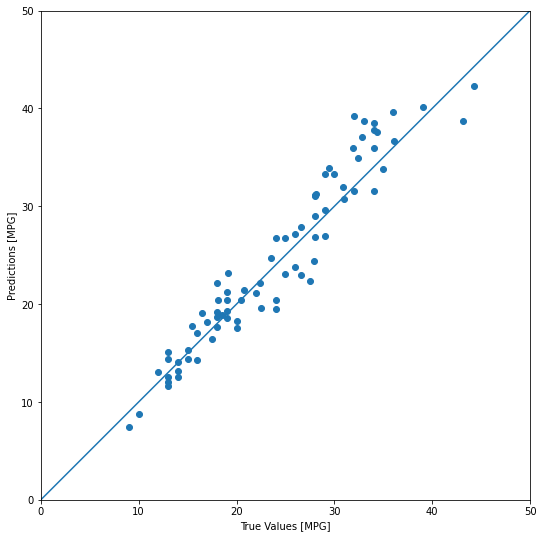

In [102]:
test_predictions = model.predict(normed_test_data).flatten()
plt.figure(figsize=(16,9))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [103]:
test_predictions.shape

(78,)

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

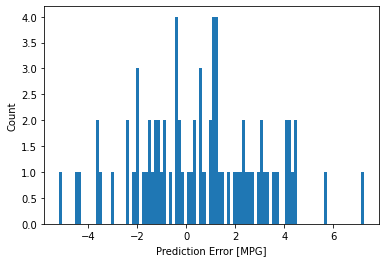

In [104]:
error = test_predictions - test_labels
plt.hist(error, bins = 100)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.